In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special

In [ ]:
class Simple_Dist:
    
    # param = [(x,density)]
    # constructed left-to-right on [init[0][0],end]
    # dist pairs stored as inclusive left end
    def __init__(self, init, end):
        self.param = init
        self.start = init[0][0]
        self.end = end
        
    def display(self):
        points = []
        a_param = self.param + [(self.end,self.param[-1][1])]
        for i, v in enumerate(a_param[:-1]):
            points.append(v)
            points.append((a_param[i+1][0],v[1]))
        x,y = zip(*points)
        plt.plot(x,y)
        plt.title("Median Density")
        plt.ylabel("Density")
        plt.xlabel("Value")
    
    def cdf(self,threshold):
        basis = []
        val = []
        a_param = self.param + [(self.end,self.param[-1][1])]
        for i, v in enumerate(a_param):
            if v[0] < threshold:
                basis.append(v[0])
                val.append(v[1])
            else:
                basis.append(threshold)
                cdf = 0
                for i, d in enumerate(val):
                    cdf += d*(basis[i+1]-basis[i])
                return cdf
    
    def invcdf(self, prob):
      a_param = self.param + [(self.end,self.param[-1][1])]
      cdf = 0
      for i, v in enumerate(a_param[:-1]):
        if cdf+v[1]*(a_param[i+1][0]-a_param[i][0])>prob:
          exceed = cdf+v[1]*(a_param[i+1][0]-a_param[i][0])-prob
          return a_param[i+1][0]-exceed/v[1]
        else:
          cdf += v[1]*(a_param[i+1][0]-a_param[i][0])

    def median(self):
      return self.invcdf(0.5)

    # Vote indicates 
    def update_dist(self, left, right, vote, alpha = 0.1):

        temp = self.param+[(self.end,self.param[-1][1])]
        
        # Insert new data(s)
        # index1 = next(i for i,v in enumerate(self.param+[(self.end,self.param[-1][1])]) if right <= v[0])
        index1 = 0
        for i in range(len(temp)):
          if temp[i][0] > right:
            break
          index1 += 1

        if index1 < len(self.param) and self.param[index1][0] != right:
            self.param.insert(index1,(right,self.param[index1-1][1]))
        elif index1 >= len(self.param) and right != self.end:
            self.param.insert(index1,(right,self.param[index1-1][1]))

        index2 = 0
        for i in range(len(temp)):
          if temp[i][0] >= left:
            break
          index2 += 1
          
        if index2 < len(self.param) and self.param[index2][0] != left:
            self.param.insert(index2,(left,self.param[index2-1][1]))
        elif index2 >= len(self.param):
            self.param.insert(index2,(left,self.param[index2-1][1]))

        # print('start')
        # for p in self.param:
        #   print(p)
        # print('end')
            
        # Modify distribution
        if vote == -1:
            # r_mass = 1 - self.cdf(right)
            for i, v in enumerate(self.param):
                if left <= v[0] < right:
                    self.param[i] = (v[0],v[1] * (1 - alpha))
                else:
                    self.param[i] = (v[0],v[1] * alpha)
            norm = self.cdf(self.end)
            for i, v in enumerate(self.param):
                self.param[i] = (v[0], v[1]/norm)
        else:
            # l_mass = self.cdf(right)
            for i, v in enumerate(self.param):
                # print(v)
                if left <= v[0] < right:
                    # print('increase')
                    self.param[i] = (v[0],v[1] * (1 - alpha))
                else:
                    self.param[i] = (v[0],v[1] * alpha)
                    # print('decrease')

            norm = self.cdf(self.end)
            for i, v in enumerate(self.param):
                self.param[i] = (v[0], v[1]/norm)


In [ ]:
# true metric
m_star = (-0.94,-0.34) #200 degree
m_star = (0.98,0.17) #11.47 degree

m_star = m_star/np.linalg.norm(m_star)  # normalize
# obtain true theta
t_true = np.arccos(m_star[0])
if t_true > np.pi/2:  # make sure theta either in [0, pi/2] or [pi, 3/2*pi]
    t_true = np.pi*2-t_true

print(t_true)

def eta(x):
  return 1/(1+np.exp(5*x))

zeta = 0.5  # f_X /sim U(-1,1)

# implementation of proposition 1
# return a classifier with t
def h_bar(t):
  m11, m00 = np.cos(t), np.sin(t)
  def hb(x):
    if m11+m00 >= 0:
      return int(eta(x)>=m00/(m11+m00))
    else:
      return int(eta(x)<=m00/(m11+m00))
  return hb

# confusion matrix, analytical solution
def C11(t):  # P(Y=1, h=1)
  m11,m00 = np.cos(t), np.sin(t)
  x_prime = 0.
  h = h_bar(t)
  if m00 == 0:
    x_prime = 1
  elif m11/m00 <= 0:
    x_prime = -1
  else:
    x_prime = np.log(m11/m00)/5
    if x_prime > 1:
      x_prime = 1
    elif x_prime < -1:
      x_prime = -1
  if m00+m11 >= 0:
    return (x_prime-0.2*np.log(1+np.exp(5*x_prime))+1+0.2*np.log(1+np.exp(-5))) # x-0.2ln(1+e^5x)
  else:
    return (1-0.2*np.log(1+np.exp(5))-x_prime+0.2*np.log(1+np.exp(5*x_prime)))

def C10(t):  # P(Y=0, h=1)
  return 1-C11(t)

def C01(t):  # P(Y=1, h=0)
  return 1-C00(t)

def C00(t):  # P(Y=0, h=0)
  m11,m00 = np.cos(t), np.sin(t)
  x_prime = 0
  h = h_bar(t)
  if m00 == 0:
    x_prime = 1
  elif (m00+m11)/m00-1 <= 0:
    x_prime = -1
  else:
    x_prime = np.log(m11/m00)/5
    if x_prime > 1:
      x_prime = 1
    elif x_prime < -1:
      x_prime = -1
  if m00+m11 >= 0:
    return (0.2*np.log(1+np.exp(5))-0.2*np.log(1+np.exp(5*x_prime)))  # ln(1+e^5x)
  else:
    return (0.2*np.log(1+np.exp(5*x_prime))-0.2*np.log(1+np.exp(-5)))

# metric evaluation
def phi(t):
  m11, m00 = np.cos(t_true), np.sin(t_true)
  return m11*C11(t)+m00*C00(t)

# query function (always maximize phi function)
# alpha: error rate —— with probability alpha, the oracle will return wrong answer
def query(t_1, t_2, alpha):
  if phi(t_1) < phi(t_2):
    if np.random.rand() > alpha:
      return 1  # prefer t2
    else:
      return 0
  else:
    if np.random.rand() > alpha:
      return 0  # prefer t1
    else:
      return 1

# def query(t_1, t_2, alpha):
#   if phi(t_1) < phi(t_2):
#     if np.random.rand() > alpha:
#       return 1  # prefer t2
#     else:
#       return 0
#   else:
#     if np.random.rand() > alpha:
#       return 0  # prefer t1
#     else:
#       return 1

0.17176015132820346


In [ ]:
# implements algorithm 1
# analytical version
# alpha: error rate of oracle
def max_quasiconcave_metric_naive(eps, alpha):
  t_a = 0
  t_b = np.pi/2
  dist = Simple_Dist(init=[(t_a,1/(t_b-t_a))],end=t_b)
  m_bar = np.zeros(2)
  C_bar = 0
  for iter in range(100):
    ct = dist.median()
    if ct < t_true:
      if np.random.rand() > alpha:
        dist.update_dist(ct,1, alpha = alpha)
      else:
        dist.update_dist(ct,-1, alpha = alpha)
    else:
      if np.random.rand() > alpha:
        dist.update_dist(ct,-1, alpha = alpha)
      else:
        dist.update_dist(ct,1, alpha = alpha)
    # dist.display()
  
  ct = dist.median()
  C_ct = np.array([[C00(ct), C01(ct)],[C10(ct), C11(ct)]])
  m_bar[0], m_bar[1] = np.cos(ct), np.sin(ct)
  C_bar = C_ct
  iter += 1
  # print("iteration run:"+str(iter))
  return m_bar,C_bar

[(0, 0.6366197723675814)]
0.39269908169872414
0.7853981633974483
1.1780972450961724
(0, 0.6366197723675814)
decrease
(0.39269908169872414, 0.6366197723675814)
increase
(1.1780972450961724, 0.6366197723675814)
decrease
[(0, 0.12732395447351627), (0.39269908169872414, 1.1459155902616465), (1.1780972450961724, 0.12732395447351627)]


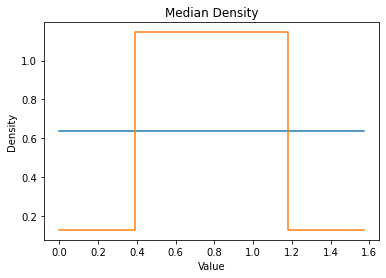

In [ ]:
t_a = 0
t_b = np.pi/2
dist = Simple_Dist(init=[(t_a,1/(t_b-t_a))],end=t_b)
dist.display()
print(dist.param)
t_c = dist.invcdf(0.25)
t_d = dist.invcdf(0.5)
t_e = dist.invcdf(0.75)
print(t_c)
print(t_d)
print(t_e)
dist.update_dist(left=t_c, right=t_e, vote=1, alpha=0.1)
print(dist.param)

dist.display()


In [ ]:
def max_quasiconcave_metric(eps, alpha):
  t_a = 0
  t_b = np.pi/2
  dist = Simple_Dist(init=[(t_a,1/(t_b-t_a))],end=t_b)

  m_bar = np.zeros(2)
  C_bar = 0
  iter = 0
  # while np.linalg.norm(t_a-t_b) > eps:
  # dist.display()
  for _ in range(100):
    # dist.display()
    # divide the searching range into equally seperated intervals
    t_c = dist.invcdf(0.25)
    t_d = dist.invcdf(0.5)
    t_e = dist.invcdf(0.75)
    # compute Confusion Matrices
    # C_a = np.array([[C00(t_a), C01(t_a)],[C10(t_a), C11(t_a)]])
    # C_b = np.array([[C00(t_b), C01(t_b)],[C10(t_b), C11(t_b)]])
    # C_c = np.array([[C00(t_c), C01(t_c)],[C10(t_c), C11(t_c)]])
    # C_d = np.array([[C00(t_d), C01(t_d)],[C10(t_d), C11(t_d)]])
    # C_e = np.array([[C00(t_e), C01(t_e)],[C10(t_e), C11(t_e)]])
    # pairwise comparisons
    ca = query(t_c, t_a, alpha)
    dc = query(t_d, t_c, alpha)
    ed = query(t_e, t_d, alpha)
    be = query(t_b, t_e, alpha)

    # sanity check for out-of-order responses
    if ca and not dc:
      ca = not ca
    if dc and not ed:
      dc = not dc
    if ed and not be:
      ed = not ed

    # determine the next iter search range based on oracle resposne to query
    if ca:         # region a-d
      dist.update_dist(left=t_a, right=t_d, vote=1, alpha=alpha)
    elif not ca and dc: # region a-d
      dist.update_dist(left=t_a, right=t_d, vote=1, alpha=alpha)
    elif not dc and ed: # region c-e
      dist.update_dist(left=t_c, right=t_e, vote=1, alpha=alpha)
    elif not ed and be: # region d-b
      dist.update_dist(left=t_d, right=t_b, vote=1, alpha=alpha)
    else:          # region d-b
      dist.update_dist(left=t_d, right=t_b, vote=1, alpha=alpha)
    iter += 1
  
  ct = dist.median()
  C_ct = np.array([[C00(ct), C01(ct)],[C10(ct), C11(ct)]])
  m_bar[0], m_bar[1] = np.cos(ct), np.sin(ct)
  C_bar = C_ct
  # print("iteration run:"+str(iter))
  return m_bar,C_bar

true metric: [0.98528545 0.17091686]
elicited metric: [0.98528532 0.17091761]
confusion matrix: 
[[0.61900008 0.38099992]
 [0.03064999 0.96935001]]


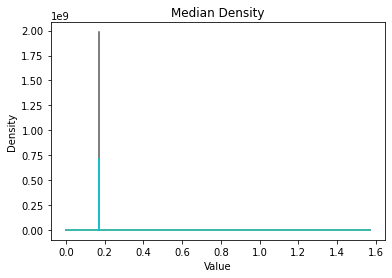

In [ ]:
m,C = max_quasiconcave_metric(1e-4, 0.1)
print("true metric: "+str(m_star))
print("elicited metric: "+str(m))
print("confusion matrix: \n"+str(C))

# Visualization of $\phi$


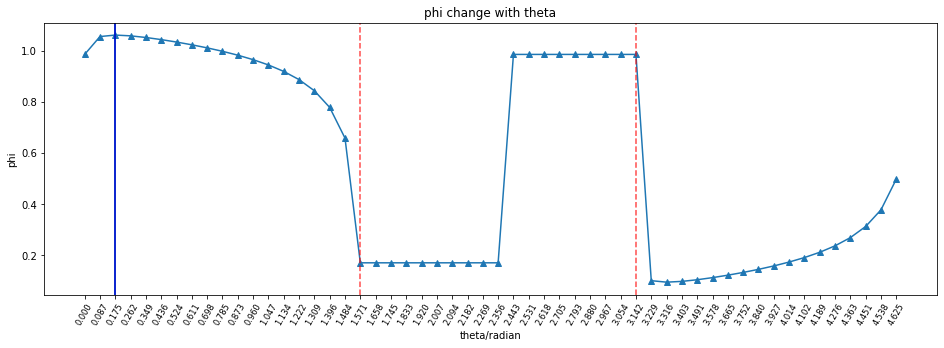

In [ ]:
# Plot phi function versus different thetas
ph = []
for i in np.arange(0, np.pi*1.5, np.pi/36):
  ph.append(phi(i))

plt.figure(figsize=(16,5))
plt.plot(np.arange(0, np.pi*1.5, np.pi/36), ph, "^-")
for p in np.arange(0.5, 1.5, 0.5):
  plt.axvline(x=np.pi*p, c='r', ls='--', alpha=0.7)
plt.axvline(x=t_true, c='g')
t_elicited = np.arccos(m[0])
if t_elicited > np.pi/2:  # make sure theta either in [0, pi/2] or [pi, 3/2*pi]
    t_elicited = np.pi*2-t_elicited
plt.axvline(x=t_elicited, c='b')
# plt.axvline(x=np.arccos(np.pi/4), c='black')
plt.xticks(np.arange(0, np.pi*1.5, np.pi/36), rotation=60, size="small")
plt.title("phi change with theta")
plt.xlabel("theta/radian")
plt.ylabel("phi")
plt.show()

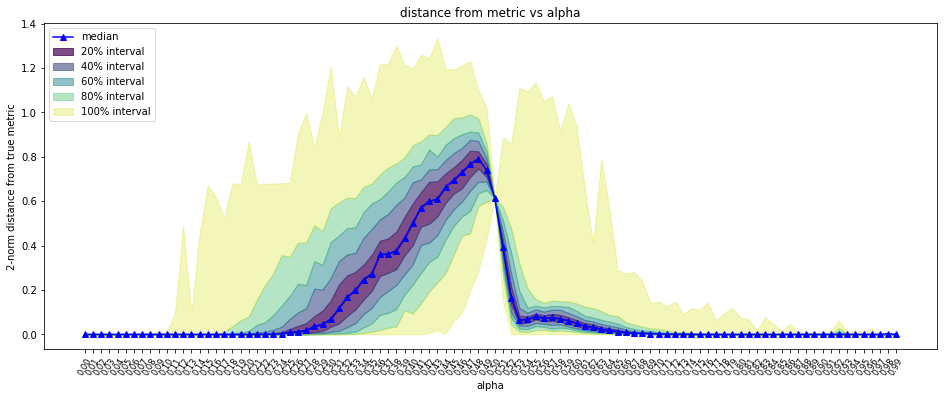

In [ ]:
num_itr = 500
step = 0.01

re_arr = np.zeros((100,num_itr))

for itr in range(num_itr):
  for lp, al in enumerate(np.arange(0., 1., step)):
    m,C = max_quasiconcave_metric(1e-4, al)
    # re.append(abs(phi2(m[0], m[1])-phi2(m_star[0], m_star[1])))
    t = np.arccos(m[0])
    if t > np.pi/2:
      t = np.pi*2-t
    re_arr[lp][itr] = np.linalg.norm(t-t_true)

re_max = np.amax(re_arr, 1)
re_min = np.amin(re_arr, 1)
re_mean = np.mean(re_arr, 1)
re_median = np.median(re_arr, 1)

fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

# ax.plot(np.arange(0., 1., step), re_max, "-", color='b', alpha=0.2) # plot maximum deviation
# ax.plot(np.arange(0., 1., step), re_min, "-", color='b', alpha=0.2) # plot minimum deviation
ax.plot(np.arange(0., 1., step), re_median, "^-", color='b', alpha=1, label='median') # plot mean relative error

cm = plt.get_cmap('viridis')
i=0
up_prev = re_median
low_prev = re_median
for i,pct in enumerate(range(40, 0, -10)):

  re_up = np.percentile(re_arr, 100-pct, 1)
  re_low = np.percentile(re_arr, pct, 1)
  ax.fill_between(np.arange(0., 1., step), re_up, up_prev, color=cm.colors[i*60], alpha=pct/100+0.3, label=str(100-2*pct)+'% interval')
  ax.fill_between(np.arange(0., 1., step), re_low, low_prev, color=cm.colors[i*60], alpha=pct/100+0.3)
  up_prev = re_up
  low_prev = re_low

ax.fill_between(np.arange(0., 1., step), re_max, up_prev, color=cm.colors[(i+1)*60], alpha=0.3, label='100% interval')
ax.fill_between(np.arange(0., 1., step), re_min, low_prev, color=cm.colors[(i+1)*60], alpha=0.3)

# plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 1, step=step), rotation=60, size="small")
plt.title("distance from metric vs alpha")
plt.xlabel("alpha")
plt.ylabel("2-norm distance from true metric")
plt.legend(loc='upper left')
plt.show()

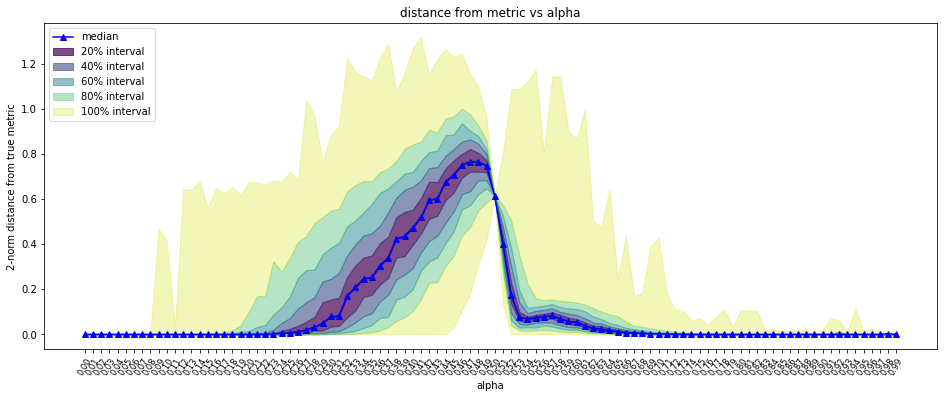

In [ ]:
num_itr = 500
step = 0.01

re_arr = np.zeros((100,num_itr))

for itr in range(num_itr):
  for lp, al in enumerate(np.arange(0., 1., step)):
    m,C = max_quasiconcave_metric(1e-4, al)
    # re.append(abs(phi2(m[0], m[1])-phi2(m_star[0], m_star[1])))
    t = np.arccos(m[0])
    if t > np.pi/2:
      t = np.pi*2-t
    re_arr[lp][itr] = np.linalg.norm(t-t_true)

re_max = np.amax(re_arr, 1)
re_min = np.amin(re_arr, 1)
re_mean = np.mean(re_arr, 1)
re_median = np.median(re_arr, 1)

fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

# ax.plot(np.arange(0., 1., step), re_max, "-", color='b', alpha=0.2) # plot maximum deviation
# ax.plot(np.arange(0., 1., step), re_min, "-", color='b', alpha=0.2) # plot minimum deviation
ax.plot(np.arange(0., 1., step), re_median, "^-", color='b', alpha=1, label='median') # plot mean relative error

cm = plt.get_cmap('viridis')
i=0
up_prev = re_median
low_prev = re_median
for i,pct in enumerate(range(40, 0, -10)):

  re_up = np.percentile(re_arr, 100-pct, 1)
  re_low = np.percentile(re_arr, pct, 1)
  ax.fill_between(np.arange(0., 1., step), re_up, up_prev, color=cm.colors[i*60], alpha=pct/100+0.3, label=str(100-2*pct)+'% interval')
  ax.fill_between(np.arange(0., 1., step), re_low, low_prev, color=cm.colors[i*60], alpha=pct/100+0.3)
  up_prev = re_up
  low_prev = re_low

ax.fill_between(np.arange(0., 1., step), re_max, up_prev, color=cm.colors[(i+1)*60], alpha=0.3, label='100% interval')
ax.fill_between(np.arange(0., 1., step), re_min, low_prev, color=cm.colors[(i+1)*60], alpha=0.3)

# plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 1, step=step), rotation=60, size="small")
plt.title("distance from metric vs alpha")
plt.xlabel("alpha")
plt.ylabel("2-norm distance from true metric")
plt.legend(loc='upper left')
plt.show()

# Non-PBA comparison

In [ ]:
# implements algorithm 1
# analytical version
# alpha: error rate of oracle
def max_quasiconcave_metric_nPBA(eps, alpha):
  t_a = 0
  t_b = np.pi/2
  m_bar = np.zeros(2)
  C_bar = 0
  iter = 0
  while np.linalg.norm(t_a-t_b) > eps:
    # divide the searching range into equally seperated intervals
    t_c = (3*t_a+t_b)/4
    t_d = (t_a+t_b)/2
    t_e = (t_a+3*t_b)/4
    # compute Confusion Matrices
    C_a = np.array([[C00(t_a), C01(t_a)],[C10(t_a), C11(t_a)]])
    C_b = np.array([[C00(t_b), C01(t_b)],[C10(t_b), C11(t_b)]])
    C_c = np.array([[C00(t_c), C01(t_c)],[C10(t_c), C11(t_c)]])
    C_d = np.array([[C00(t_d), C01(t_d)],[C10(t_d), C11(t_d)]])
    C_e = np.array([[C00(t_e), C01(t_e)],[C10(t_e), C11(t_e)]])
    # pairwise comparisons
    ca = query(t_c, t_a, alpha)
    dc = query(t_d, t_c, alpha)
    ed = query(t_e, t_d, alpha)
    be = query(t_b, t_e, alpha)

    # sanity check for out-of-order responses
    if ca and not dc:
      ca = not ca
    if dc and not ed:
      dc = not dc
    if ed and not be:
      ed = not ed

    # determine the next iter search range based on oracle resposne to query
    if ca:
      t_b = t_d
    elif not ca and dc:
      t_b = t_d
    elif not dc and ed:
      t_a = t_c
      t_b = t_e
    elif not ed and be:
      t_a = t_d
    else:
      t_a = t_d
    m_bar[0], m_bar[1] = np.cos(t_d), np.sin(t_d)
    C_bar = C_d
    iter += 1
  # print("iteration run:"+str(iter))
  return m_bar,C_bar

In [ ]:
m,C = max_quasiconcave_metric_nPBA(1e-4, 0.2)
print("true metric: "+str(m_star))
print("elicited metric: "+str(m))
print("confusion matrix: \n"+str(C))

true metric: [0.98528545 0.17091686]
elicited metric: [0.69775841 0.71633316]
confusion matrix: 
[[0.86532362 0.13467638]
 [0.13993087 0.86006913]]


In [ ]:
num_itr = 500
step = 0.01

re_arr_nPBA = np.zeros((100,num_itr))

for itr in range(num_itr):
  for lp, al in enumerate(np.arange(0., 1., step)):
    m,C = max_quasiconcave_metric_nPBA(1e-4, al)
    # re.append(abs(phi2(m[0], m[1])-phi2(m_star[0], m_star[1])))
    t = np.arccos(m[0])
    if t > np.pi/2:
      t = np.pi*2-t
    re_arr_nPBA[lp][itr] = np.linalg.norm(t-t_true)

re_max_nPBA = np.amax(re_arr_nPBA, 1)
re_min_nPBA = np.amin(re_arr_nPBA, 1)
re_mean_nPBA = np.mean(re_arr_nPBA, 1)
re_median_nPBA = np.median(re_arr_nPBA, 1)

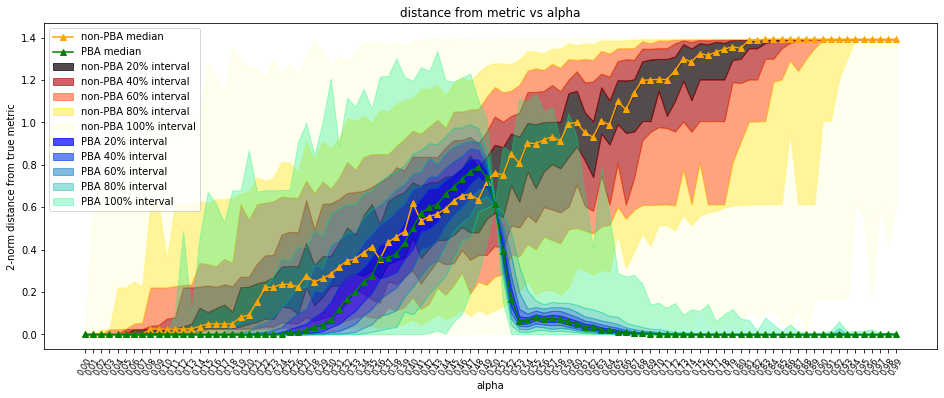

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

# ax.plot(np.arange(0., 1., step), re_max, "-", color='b', alpha=0.2) # plot maximum deviation
# ax.plot(np.arange(0., 1., step), re_min, "-", color='b', alpha=0.2) # plot minimum deviation
ax.plot(np.arange(0., 1., step), re_median_nPBA, "^-", color='orange', alpha=1, label='non-PBA median') # plot mean relative error
ax.plot(np.arange(0., 1., step), re_median, "^-", color='g', alpha=1, label='PBA median') # plot mean relative error

cm = plt.get_cmap('hot')
i=0
up_prev = re_median_nPBA
low_prev = re_median_nPBA
for i,pct in enumerate(range(40, 0, -10)):

  re_up = np.percentile(re_arr_nPBA, 100-pct, 1)
  re_low = np.percentile(re_arr_nPBA, pct, 1)
  ax.fill_between(np.arange(0., 1., step), re_up, up_prev, color=cm(i*60/256), alpha=pct/100+0.3, label='non-PBA '+str(100-2*pct)+'% interval')
  ax.fill_between(np.arange(0., 1., step), re_low, low_prev, color=cm(i*60/256), alpha=pct/100+0.3)
  up_prev = re_up
  low_prev = re_low

ax.fill_between(np.arange(0., 1., step), re_max_nPBA, up_prev, color=cm((i+1)*60/256), alpha=0.3, label='non-PBA '+'100% interval')
ax.fill_between(np.arange(0., 1., step), re_min_nPBA, low_prev, color=cm((i+1)*60/256), alpha=0.3)

################################################################### Plot for PBA #############################################################################

cm = plt.get_cmap('winter')
i=0
up_prev = re_median
low_prev = re_median
for i,pct in enumerate(range(40, 0, -10)):

  re_up = np.percentile(re_arr, 100-pct, 1)
  re_low = np.percentile(re_arr, pct, 1)
  ax.fill_between(np.arange(0., 1., step), re_up, up_prev, color=cm(i*60/256), alpha=pct/100+0.3, label='PBA '+str(100-2*pct)+'% interval')
  ax.fill_between(np.arange(0., 1., step), re_low, low_prev, color=cm(i*60/256), alpha=pct/100+0.3)
  up_prev = re_up
  low_prev = re_low

ax.fill_between(np.arange(0., 1., step), re_max, up_prev, color=cm((i+1)*60/256), alpha=0.3, label='PBA '+'100% interval')
ax.fill_between(np.arange(0., 1., step), re_min, low_prev, color=cm((i+1)*60/256), alpha=0.3)

# plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 1, step=step), rotation=60, size="small")
plt.title("distance from metric vs alpha")
plt.xlabel("alpha")
plt.ylabel("2-norm distance from true metric")
plt.legend(loc='upper left')
plt.show()

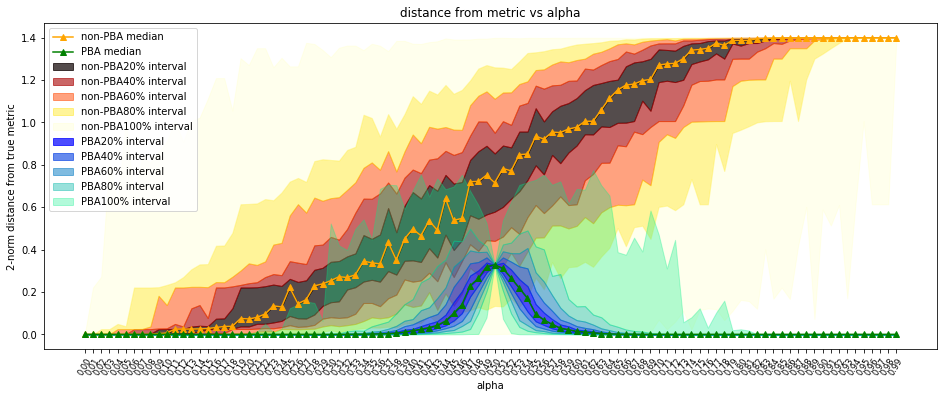

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

# ax.plot(np.arange(0., 1., step), re_max, "-", color='b', alpha=0.2) # plot maximum deviation
# ax.plot(np.arange(0., 1., step), re_min, "-", color='b', alpha=0.2) # plot minimum deviation
ax.plot(np.arange(0., 1., step), re_median_nPBA, "^-", color='orange', alpha=1, label='non-PBA median') # plot mean relative error
ax.plot(np.arange(0., 1., step), re_median, "^-", color='g', alpha=1, label='PBA median') # plot mean relative error

cm = plt.get_cmap('hot')
i=0
up_prev = re_median_nPBA
low_prev = re_median_nPBA
for i,pct in enumerate(range(40, 0, -10)):

  re_up = np.percentile(re_arr_nPBA, 100-pct, 1)
  re_low = np.percentile(re_arr_nPBA, pct, 1)
  ax.fill_between(np.arange(0., 1., step), re_up, up_prev, color=cm(i*60/256), alpha=pct/100+0.3, label='non-PBA '+str(100-2*pct)+'% interval')
  ax.fill_between(np.arange(0., 1., step), re_low, low_prev, color=cm(i*60/256), alpha=pct/100+0.3)
  up_prev = re_up
  low_prev = re_low

ax.fill_between(np.arange(0., 1., step), re_max_nPBA, up_prev, color=cm((i+1)*60/256), alpha=0.3, label='non-PBA '+'100% interval')
ax.fill_between(np.arange(0., 1., step), re_min_nPBA, low_prev, color=cm((i+1)*60/256), alpha=0.3)

################################################################### Plot for PBA #############################################################################

cm = plt.get_cmap('winter')
i=0
up_prev = re_median
low_prev = re_median
for i,pct in enumerate(range(40, 0, -10)):

  re_up = np.percentile(re_arr, 100-pct, 1)
  re_low = np.percentile(re_arr, pct, 1)
  ax.fill_between(np.arange(0., 1., step), re_up, up_prev, color=cm(i*60/256), alpha=pct/100+0.3, label='PBA '+str(100-2*pct)+'% interval')
  ax.fill_between(np.arange(0., 1., step), re_low, low_prev, color=cm(i*60/256), alpha=pct/100+0.3)
  up_prev = re_up
  low_prev = re_low

ax.fill_between(np.arange(0., 1., step), re_max, up_prev, color=cm((i+1)*60/256), alpha=0.3, label='PBA '+'100% interval')
ax.fill_between(np.arange(0., 1., step), re_min, low_prev, color=cm((i+1)*60/256), alpha=0.3)

# plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 1, step=step), rotation=60, size="small")
plt.title("distance from metric vs alpha")
plt.xlabel("alpha")
plt.ylabel("2-norm distance from true metric")
plt.legend(loc='upper left')
plt.show()

In [ ]:
cm = plt.get_cmap('Reds')
print(cm(0.3))

(0.9882352941176471, 0.6715417147251057, 0.5605382545174933, 1.0)


# without out of order check in algorithm 1

In [ ]:
# implements algorithm 1
# analytical version
# alpha: error rate of oracle
def max_quasiconcave_metric_nPBA(eps, alpha):
  t_a = 0
  t_b = np.pi/2
  m_bar = np.zeros(2)
  C_bar = 0
  iter = 0
  while np.linalg.norm(t_a-t_b) > eps:
    # divide the searching range into equally seperated intervals
    t_c = (3*t_a+t_b)/4
    t_d = (t_a+t_b)/2
    t_e = (t_a+3*t_b)/4
    # compute Confusion Matrices
    C_a = np.array([[C00(t_a), C01(t_a)],[C10(t_a), C11(t_a)]])
    C_b = np.array([[C00(t_b), C01(t_b)],[C10(t_b), C11(t_b)]])
    C_c = np.array([[C00(t_c), C01(t_c)],[C10(t_c), C11(t_c)]])
    C_d = np.array([[C00(t_d), C01(t_d)],[C10(t_d), C11(t_d)]])
    C_e = np.array([[C00(t_e), C01(t_e)],[C10(t_e), C11(t_e)]])
    # pairwise comparisons
    ca = query(t_c, t_a, alpha)
    dc = query(t_d, t_c, alpha)
    ed = query(t_e, t_d, alpha)
    be = query(t_b, t_e, alpha)

    # sanity check for out-of-order responses
    # if ca and not dc:
    #   ca = not ca
    # if dc and not ed:
    #   dc = not dc
    # if ed and not be:
    #   ed = not ed

    # determine the next iter search range based on oracle resposne to query
    if ca:
      t_b = t_d
    elif not ca and dc:
      t_b = t_d
    elif not dc and ed:
      t_a = t_c
      t_b = t_e
    elif not ed and be:
      t_a = t_d
    else:
      t_a = t_d
    m_bar[0], m_bar[1] = np.cos(t_d), np.sin(t_d)
    C_bar = C_d
    iter += 1
  # print("iteration run:"+str(iter))
  return m_bar,C_bar

In [ ]:
num_itr = 2000
step = 0.01

re_arr_nPBA = np.zeros((100,num_itr))

for itr in range(num_itr):
  for lp, al in enumerate(np.arange(0., 1., step)):
    m,C = max_quasiconcave_metric_nPBA(1e-4, al)
    # re.append(abs(phi2(m[0], m[1])-phi2(m_star[0], m_star[1])))
    t = np.arccos(m[0])
    if t > np.pi/2:
      t = np.pi*2-t
    re_arr_nPBA[lp][itr] = np.linalg.norm(t-t_true)

re_max_nPBA = np.amax(re_arr_nPBA, 1)
re_min_nPBA = np.amin(re_arr_nPBA, 1)
re_mean_nPBA = np.mean(re_arr_nPBA, 1)
re_median_nPBA = np.median(re_arr_nPBA, 1)

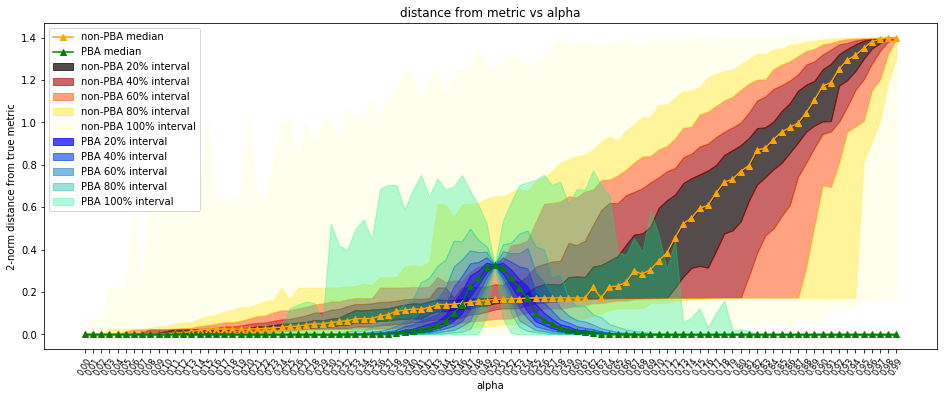

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

# ax.plot(np.arange(0., 1., step), re_max, "-", color='b', alpha=0.2) # plot maximum deviation
# ax.plot(np.arange(0., 1., step), re_min, "-", color='b', alpha=0.2) # plot minimum deviation
ax.plot(np.arange(0., 1., step), re_median_nPBA, "^-", color='orange', alpha=1, label='non-PBA median') # plot mean relative error
ax.plot(np.arange(0., 1., step), re_median, "^-", color='g', alpha=1, label='PBA median') # plot mean relative error

cm = plt.get_cmap('hot')
i=0
up_prev = re_median_nPBA
low_prev = re_median_nPBA
for i,pct in enumerate(range(40, 0, -10)):

  re_up = np.percentile(re_arr_nPBA, 100-pct, 1)
  re_low = np.percentile(re_arr_nPBA, pct, 1)
  ax.fill_between(np.arange(0., 1., step), re_up, up_prev, color=cm(i*60/256), alpha=pct/100+0.3, label='non-PBA '+str(100-2*pct)+'% interval')
  ax.fill_between(np.arange(0., 1., step), re_low, low_prev, color=cm(i*60/256), alpha=pct/100+0.3)
  up_prev = re_up
  low_prev = re_low

ax.fill_between(np.arange(0., 1., step), re_max_nPBA, up_prev, color=cm((i+1)*60/256), alpha=0.3, label='non-PBA '+'100% interval')
ax.fill_between(np.arange(0., 1., step), re_min_nPBA, low_prev, color=cm((i+1)*60/256), alpha=0.3)

################################################################### Plot for PBA #############################################################################

cm = plt.get_cmap('winter')
i=0
up_prev = re_median
low_prev = re_median
for i,pct in enumerate(range(40, 0, -10)):

  re_up = np.percentile(re_arr, 100-pct, 1)
  re_low = np.percentile(re_arr, pct, 1)
  ax.fill_between(np.arange(0., 1., step), re_up, up_prev, color=cm(i*60/256), alpha=pct/100+0.3, label='PBA '+str(100-2*pct)+'% interval')
  ax.fill_between(np.arange(0., 1., step), re_low, low_prev, color=cm(i*60/256), alpha=pct/100+0.3)
  up_prev = re_up
  low_prev = re_low

ax.fill_between(np.arange(0., 1., step), re_max, up_prev, color=cm((i+1)*60/256), alpha=0.3, label='PBA '+'100% interval')
ax.fill_between(np.arange(0., 1., step), re_min, low_prev, color=cm((i+1)*60/256), alpha=0.3)

# plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 1, step=step), rotation=60, size="small")
plt.title("distance from metric vs alpha")
plt.xlabel("alpha")
plt.ylabel("2-norm distance from true metric")
plt.legend(loc='upper left')
plt.show()